Source: [Hugging Face Github](https://github.com/huggingface/cookbook/blob/main/notebooks/en/fine_tuning_llm_grpo_trl.ipynb), modifications by christian.winkler@datanizing.com

# Post training an LLM for reasoning with GRPO in TRL

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we'll guide you through the process of post-training a Large Language Model (LLM) using **Group Relative Policy Optimization (GRPO)**, a method introduced in the [DeepSeekMath paper](https://arxiv.org/abs/2402.03300). GRPO is particularly effective for **scaling test-time compute for extended reasoning**, making it an ideal approach for solving complex tasks, such as mathematical problem-solving.

GRPO is a **reinforcement learning (RL) post-training technique** that was integrated into the training pipeline for [**DeepSeek-R1**](https://github.com/deepseek-ai/DeepSeek-R1). It seems to share similarities with the training procedures used in the latest [**OpenAI o1 and o3 models**](https://openai.com/index/learning-to-reason-with-llms/), though the exact alignment is not confirmed. Unlike earlier techniques that relied on search-heuristic methods, GRPO exclusively employs **RL** for post-training, enhancing the model's capacity to handle complex and nuanced tasks.



The GRPO technique is available through the [TRL library](https://huggingface.co/docs/trl/main/en/grpo_trainer#quick-start). At the time of writing, the Hugging Face Science team is working to reproduce the full **DeepSeek-R1** training process, which you can explore in their [Open-R1 project](https://github.com/huggingface/open-r1). I highly recommend checking it out for a deeper dive into the overall process.

In this notebook, we'll focus specifically on **post-training with GRPO**, though additional resources on DeepSeek-R1 and its training procedure are provided in the last section.

Below is a diagram illustrating how this training procedure works.









![Image](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png)

## 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
!pip install  -U -q trl peft math_verify

## 2. Dataset 📁

These models excel at tasks that require **complex reasoning**. A prime example is **mathematical problem-solving**, which often demands multi-step reasoning to arrive at a correct solution.

For this project, we'll use the [AI-MO/NuminaMath-TIR](https://huggingface.co/datasets/AI-MO/NuminaMath-TIR) dataset. This is a **reasoning-focused dataset** that contains mathematical problems, their solutions, and detailed reasoning steps that explain how to transition from the problem statement to the final solution.


## 2.2 Load dataset

In [1]:
from datasets import load_dataset
dataset_id = "openai/gsm8k"
dataset = load_dataset(dataset_id, "main", split = "train")
dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

Let's check the structure of the dataset

In [2]:
dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

Let's check one sample:

In [3]:
dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

In [4]:
dataset[1]

{'question': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?',
 'answer': 'Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute.\nWorking 50 minutes, she earned 0.2 x 50 = $<<0.2*50=10>>10.\n#### 10'}

In [5]:
def extract_hash_answer(text):
    if "####" not in text: return None
    return text.split("####")[1].strip()
extract_hash_answer(dataset[0]["answer"])

'72'

In the **DeepSeek-R1** training procedure, a specific system prompt was used to generate a conversational pipeline that includes reasoning steps. We'll adapt our dataset to follow this approach, where the model is guided to first think through the problem and then present its answer.

The system prompt used is:

```
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>. User: prompt. Assistant:
```

We will modify our dataset to follow this conversational format, prompting the LLM to generate both the reasoning steps and the final answer.








In [6]:
reasoning_start = "<think>"
reasoning_end   = "</think>"
solution_start = "<answer>"
solution_end = "</answer>"

system_prompt = \
f"""You are given a problem.
Think about the problem and provide your working out.
Place it between {reasoning_start} and {reasoning_end}.
Then, provide your solution between {solution_start}{solution_end}"""
system_prompt

'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <think> and </think>.\nThen, provide your solution between <answer></answer>'

In [7]:
dataset_r = dataset.map(lambda x: {
    "prompt" : [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": x["question"]},
    ],
    "answer": extract_hash_answer(x["answer"]),
})
dataset_r[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72',
 'prompt': [{'content': 'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <think> and </think>.\nThen, provide your solution between <answer></answer>',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]}

In [8]:
# , might be used as a separator!
sum([float(d["answer"].replace(",", "")) for d in dataset_r])

403114874.0

### 2.2 Loading Reward Functions

For the reward component of the system, we can use either pretrained reward models or reward functions defined directly in code. For training, the DeepSeek-R1 authors used an accuracy-based reward model evaluates whether the response is correct, alongside a format-based reward that ensures the model places its reasoning process between `<think> </think>` tags. You can find more details [here](https://github.com/huggingface/open-r1/blob/main/src/open_r1/grpo.py). We can simply define and implement these reward functions as generic Python functions.

In this case, we will utilize these reward functions:

1. **Format Enforcement:** Ensures that the generation follows a specific format using `<think> </think> <answer> </answer>` tags for reasoning.  

In [9]:
import re

match_format = re.compile(
    rf"^[\s]{{0,}}"\
    rf"{reasoning_start}.+?{reasoning_end}.*?"\
    rf"{solution_start}(.+?){solution_end}"\
    rf"[\s]{{0,}}$",
    flags = re.MULTILINE | re.DOTALL
)

In [10]:
# verify it works
match_format.search(
    f"{reasoning_start}Let me think!{reasoning_end}"\
    f"{solution_start}2{solution_end}",
)

<re.Match object; span=(0, 46), match='<think>Let me think!</think><answer>2</answer>'>

Let's create the reward function with `3` points for correct format.

In [11]:
def match_format_exactly(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Match if format is seen exactly!
        if match_format.search(response) is not None: score += 3.0
        scores.append(score)
    return scores

Create a finer-grained reward if the format matches partially.

In [12]:
def match_format_approximately(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Count how many keywords are seen - we penalize if too many!
        # If we see 1, then plus some points!
        score += 0.5 if response.count(reasoning_start) == 1 else -0.5
        score += 0.5 if response.count(reasoning_end)   == 1 else -0.5
        score += 0.5 if response.count(solution_start)  == 1 else -0.5
        score += 0.5 if response.count(solution_end)    == 1 else -0.5
        scores.append(score)
    return scores

2. **Solution Accuracy:** Verifies whether the solution to the problem is correct.

Extract the generated answer and calculate a reward or penalty. Close answers get small rewards.

In [13]:
def check_answer(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_format.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        score = 0
        if guess is None:
            scores.append(0)
            continue
        # Correct answer gets 3 points!
        if guess == true_answer:
            score += 3.0
        # Match if spaces are seen
        elif guess.strip() == true_answer.strip():
            score += 1.5
        else:
            # We also reward it if the answer is close via ratios!
            # Ie if the answer is within some range, reward it!
            try:
                # small change here: there might be a comma in the float
                ratio = float(guess.replace(",", "")) / float(true_answer.replace(",", ""))
                if   ratio >= 0.9 and ratio <= 1.1: score += 0.5
                elif ratio >= 0.8 and ratio <= 1.2: score += 0.25
                else: score -= 1.0 # Penalize wrong answers
            except:
                score -= 0.5 # Penalize
        scores.append(score)
    return scores

To be on the safe side also for other datasets, we also check currencies etc.

In [14]:
match_numbers = re.compile(
    rf"{solution_start}.*?([\d\.]{{1,}})",
    flags = re.MULTILINE | re.DOTALL
)
match_numbers.findall(f"{solution_start} $2.34€ {solution_end}",)

['2.34']

In [15]:
def check_numbers(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_numbers.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    print('*'*20, f"Question:\n{question}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(0)
            continue
        # Convert to numbers
        try:
            true_answer = float(true_answer.strip())
            guess       = float(guess.strip())
            scores.append(1.5 if guess == true_answer else 0.0)
        except:
            scores.append(0)
            continue
    return scores

In [16]:
dataset_r[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72',
 'prompt': [{'content': 'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <think> and </think>.\nThen, provide your solution between <answer></answer>',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]}

## 3. Post-Training the Base Model Using GRPO

The diagram below highlights the main differences between **PPO** (Proximal Policy Optimization) and **GRPO** (Group Relative Policy Optimization), specifically the removal of the value model in GRPO. For more detailed information on the key differences, you can refer to the [full explanation here](https://www.philschmid.de/deepseek-r1).

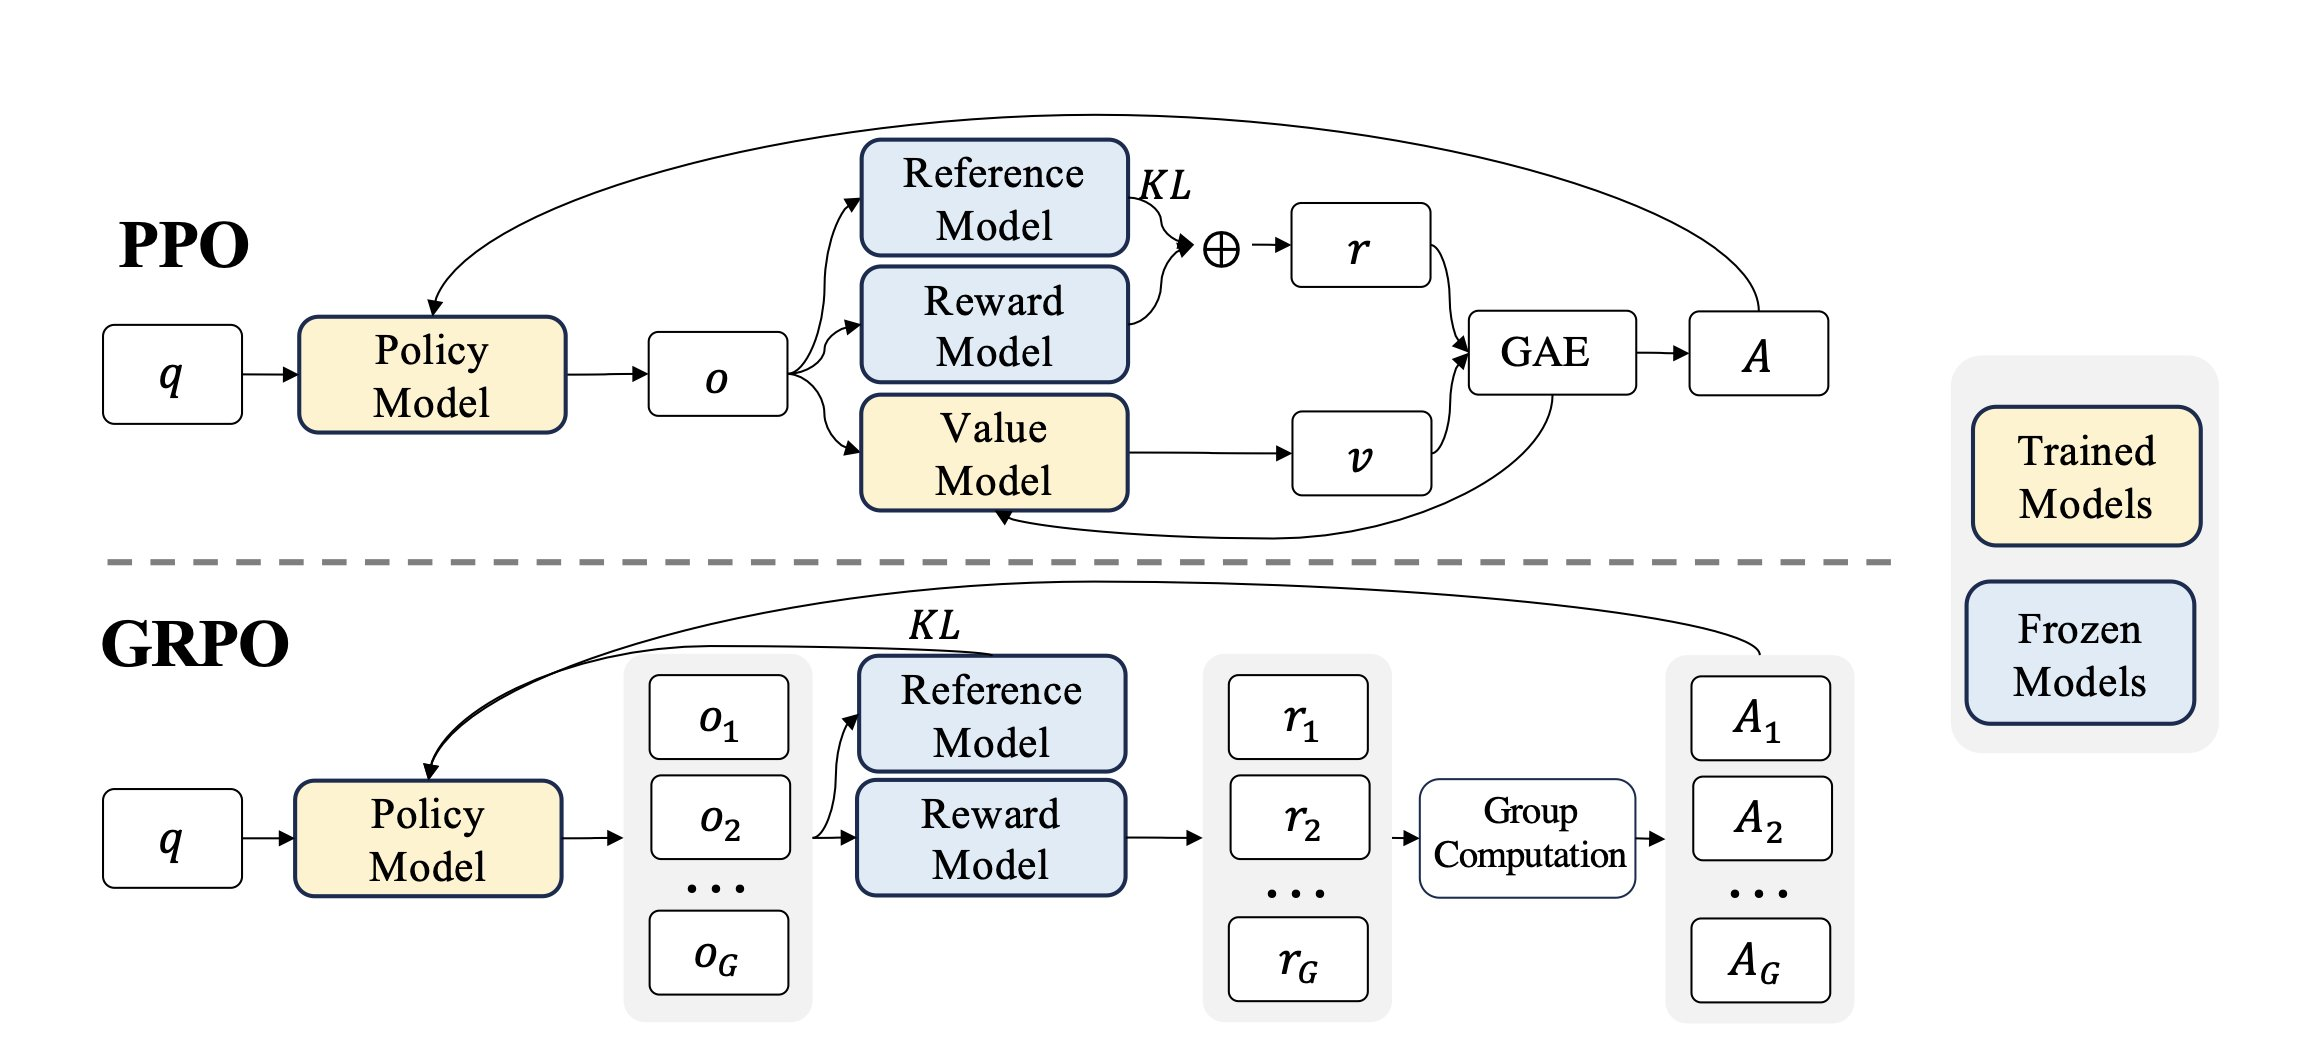

### 3.1 Loading the Baseline Model

To begin, we'll load [Qwen/Qwen2-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2-0.5B-Instruct) or alternatively [HuggingFaceTB/SmolLM2-1.7B-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct) as the baseline model (`Policy Model` in the diagram above). With only 0.5 billion parameters, it is lightweight and fits within the available resources. However, for better results, a larger [alternative](https://x.com/jiayi_pirate/status/1882839487417561307) should be considered.  


In [17]:
import torch
from liger_kernel.transformers import AutoLigerKernelForCausalLM

#model_id = "Qwen/Qwen2-0.5B-Instruct"
#model_id = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
model_id = "google/gemma-3-1b-it"
output_dir = model_id.replace("/", "_") + "-" + dataset_id.replace("/", "_") + "-GPRO"
model = AutoLigerKernelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    attn_implementation='flash_attention_2',
    device_map="auto",
)

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

### 3.2 Configuring LoRA

Next, we will configure LoRA for model training. This technique will allow us to efficiently fine-tune the model with a reduced number of parameters, enabling faster and more resource-efficient training.

In [18]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=16, # rank for the lora adapters, higher rank means higher compression (=fewer parameters)
    lora_alpha=32, # alpha should be 2x to 4x r
    lora_dropout=0, # 0.01, #0.1, # lower dropout risks overfitting
    target_modules="all-linear" # ["q_proj", "v_proj"], # could also be all-linear
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

/home/cwinkler/uv/jupyter-env/.venv/lib/python3.12/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


trainable params: 13,045,760 || all params: 1,012,931,712 || trainable%: 1.2879


### 3.4 Configuring GRPO Training Parameters

Next, let's configure the training parameters for GRPO. We recommend experimenting with the `max_completion_length`, `num_generations`, and `max_prompt_length` parameters (refer to the image at the beginning for details about each of them).

To keep things simple, we’ll start by training for just one epoch and reducing the `max_completion_length`, `num_generations`, and `max_prompt_length` from their default values.

In [19]:
from trl import GRPOConfig

# Configure training arguments using GRPOConfig
training_args = GRPOConfig(
    output_dir=output_dir,
    learning_rate=1e-5,
    remove_unused_columns=False, # to access the solution column in accuracy_reward
    gradient_accumulation_steps=16,
    num_train_epochs=4,
    bf16=True,

    # Parameters that control de data preprocessing
    max_completion_length=64, # default: 256
    num_generations=4, # default: 8
    max_prompt_length=128, # default: 512

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    save_strategy="steps",
    save_steps=10,
)

### 3.5 Training the Model 🏃

Now, let's configure the trainer and start training the model!

In this case, we pass the two reward functions we previously defined to the trainer

Below, you'll find a diagram of the training procedure we'll be reproducing, which is sourced from the [Open-R1 project](https://github.com/huggingface/open-r1).

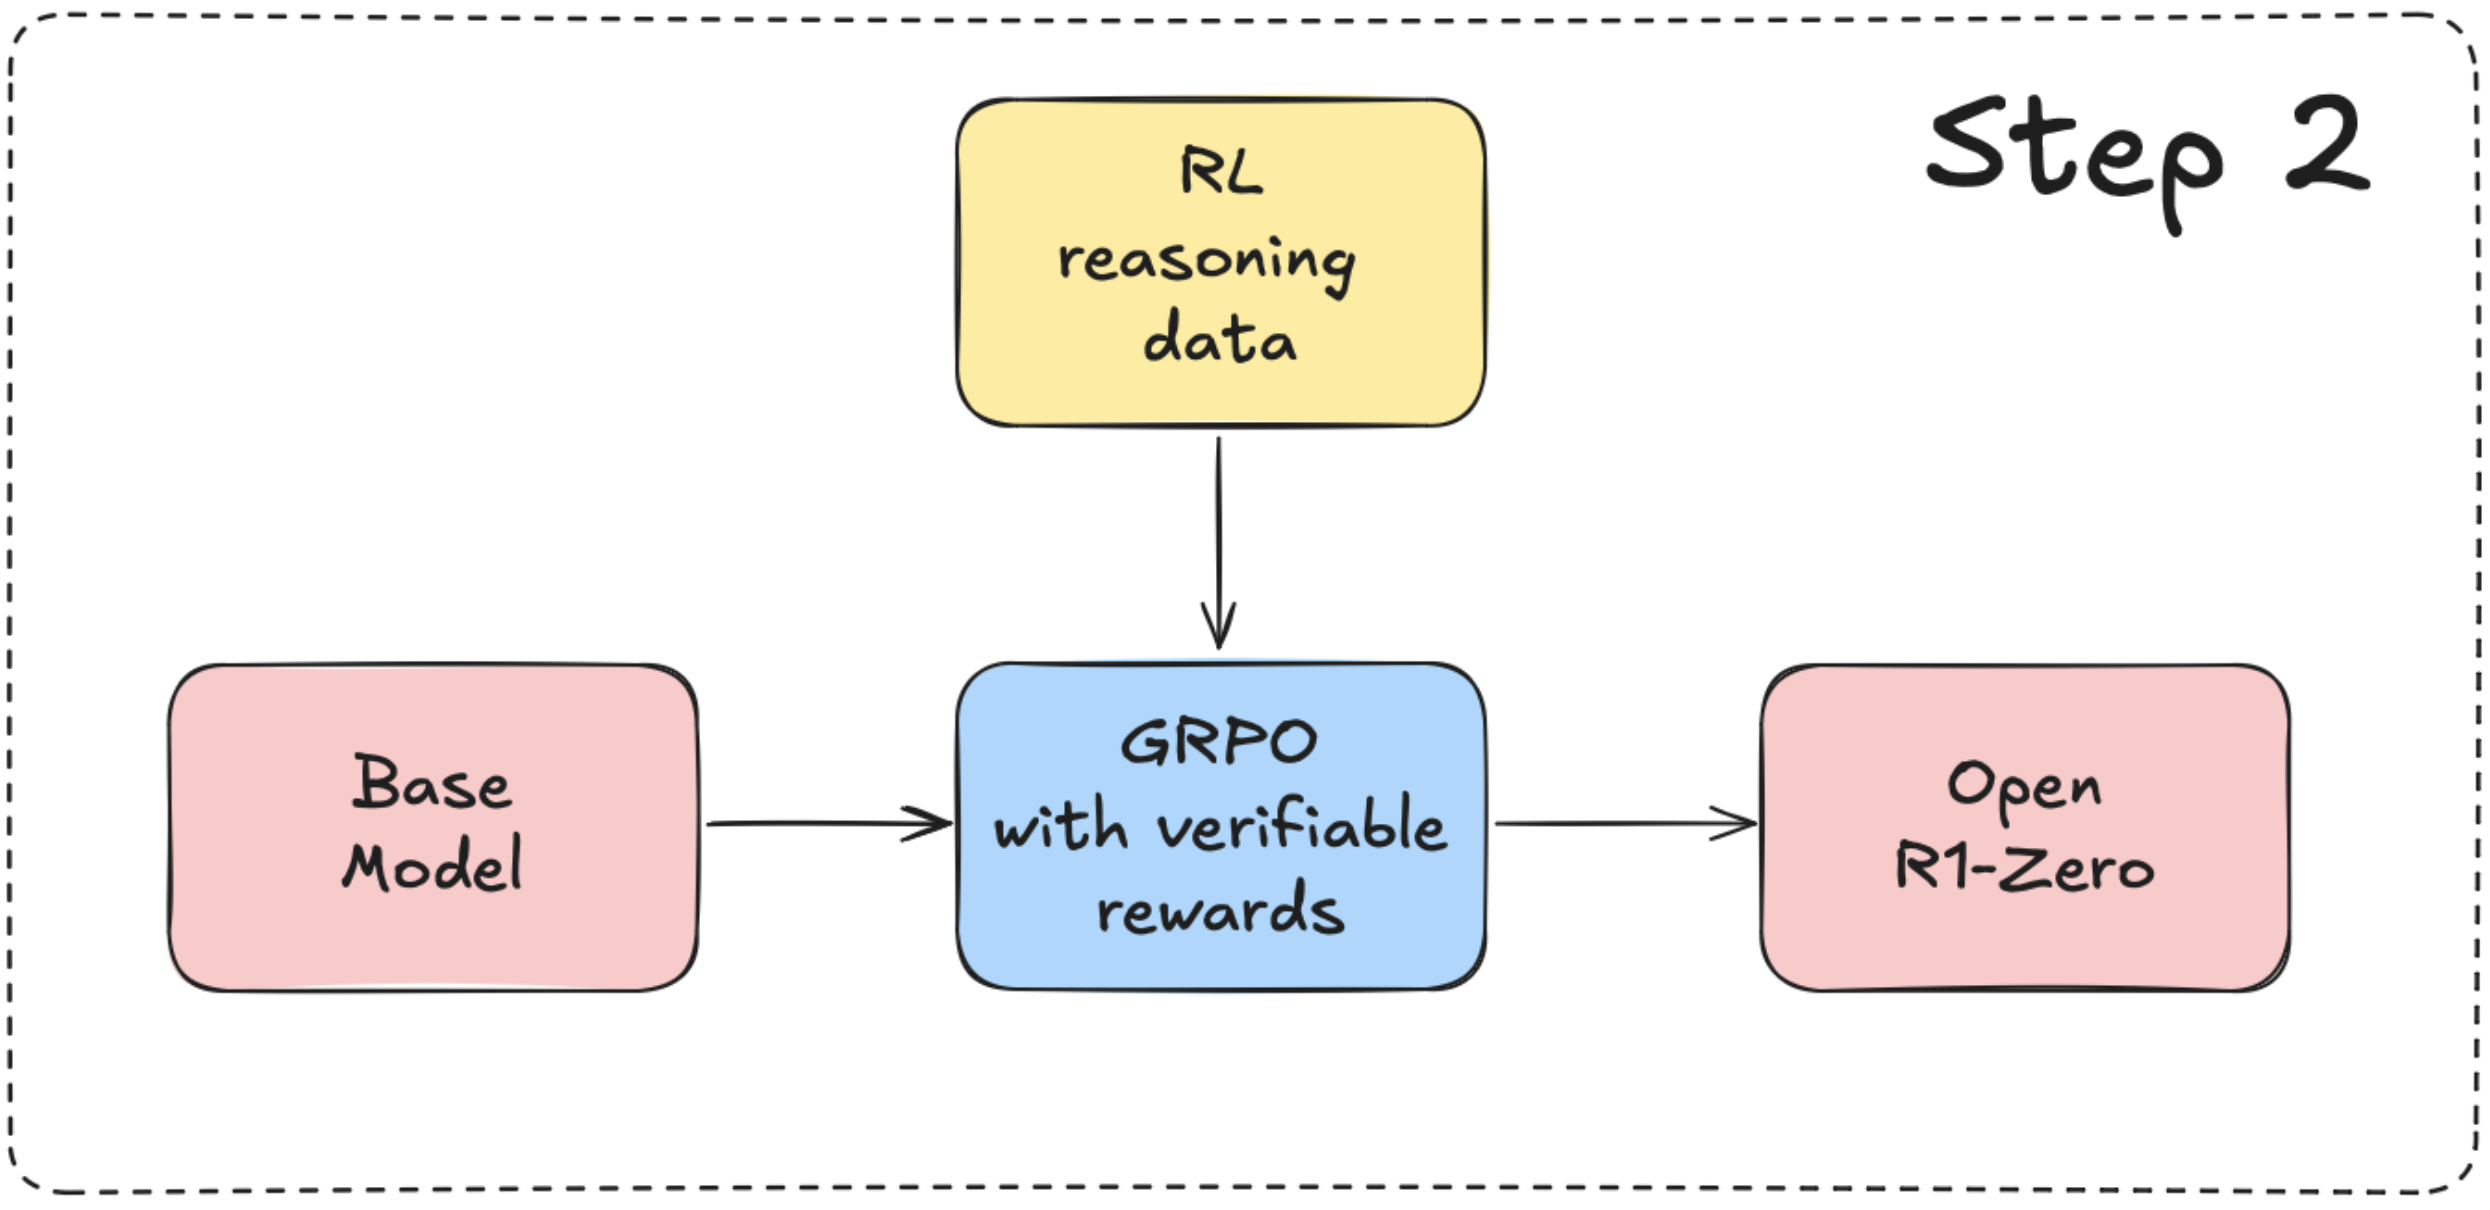

In [20]:
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    reward_funcs = [
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    args=training_args,
    train_dataset=dataset_r
)

INFO 06-08 22:02:43 [__init__.py:243] Automatically detected platform cuda.


/home/cwinkler/uv/jupyter-env/.venv/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Time to train the model! 🎉

In [21]:
trainer.train()

`generation_config` default values have been modified to match model-specific defaults: {'cache_implementation': 'hybrid', 'top_p': 0.95}. If this is not desired, please set these values explicitly.
It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `flash_attention_2`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


******************** Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
Let's analyze the scenario.

There are 9 assignments and Ahmed has a 91 in the class. Emily has a 92 in the class. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade 
Extracted:
None


Step,Training Loss
10,0.005900
20,0.004100
30,0.011000
40,0.007800
50,0.012400
60,0.014400
70,0.009800
80,0.014000
90,0.016000
100,0.014100


******************** Question:
Frank invites his friends over to play video games. He bakes a pan of brownies before he arrives. He cuts 6 even columns and 3 even rows into the pan of brownies. If there are 6 people, including Frank, in total, how many brownies can they each eat? 
Answer:
3 
Response:
<think>
Let $n$ be the number of columns and rows in the pan of brownies. We are given that Frank bakes a pan of brownies with 6 even columns and 3 even rows. So, $n = 6$ and $n = 3$. This is a contradiction. The 
Extracted:
None
******************** Question:
Michael has two brothers. His oldest brother is 1 year older than twice Michael's age when Michael was a year younger. His younger brother is 5 years old, which is a third of the age of the older brother. What is their combined age? 
Answer:
28 
Response:
<think>Let's define our variables.
Let Michael's current age be M.
Let the age of Michael's oldest brother be O.
Let the age of Michael's younger brother be Y.

We are given that t

/home/cwinkler/uv/jupyter-env/.venv/lib/python3.12/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b24e47f0-cfc8-43e0-ac56-b431d69b0185)') - silently ignoring the lookup for the file config.json in google/gemma-3-1b-it.
  warnings.warn(
/home/cwinkler/uv/jupyter-env/.venv/lib/python3.12/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in google/gemma-3-1b-it - will assume that the vocabulary was not modified.
  warnings.warn(


******************** Question:
In a 5-day Fishing competition, Jackson was able to reel a total of 6 fishes per day, Jonah was able to reel 4 fishes per day and George was able to reel 8 fishes per day. How many fishes were they able to catch throughout the competition if they are on the same team? 
Answer:
90 
Response:
<think>Let's calculate the total number of fishes caught by each person.
Jackson: 6 fishes/day * 5 days = 30 fishes
Jonah: 4 fishes/day * 5 days = 20 fishes
George: 8 fishes/day * 5 days 
Extracted:
None
******************** Question:
Jerome is taking a 150-mile bicycle trip. He wants to ride 12 miles for 12 days. How long will he ride on the 13th day to finish his goal? 
Answer:
6 
Response:
<think>
Jerome is already halfway through his trip. He has completed 12 miles in 12 days.
The total distance he wants to ride is 150 miles.
He has already ridden 12 miles.
The remaining distance is 150 - 12 
Extracted:
None
******************** Question:
Niko has bought 9 pairs of

TrainOutput(global_step=932, training_loss=0.05916017805158197, metrics={'train_runtime': 8936.0909, 'train_samples_per_second': 3.345, 'train_steps_per_second': 0.104, 'total_flos': 0.0, 'train_loss': 0.05916017805158197})

Let's save the results 💾

In [22]:
trainer.save_model(training_args.output_dir)

## 4. Check the Model Performance

We've kept things simple so far, but now let's check if the model has already learned to reason. We'll load the saved model and run an evaluation on a test sample.

In [23]:
from transformers import AutoModelForCausalLM, AutoTokenizer
local_model = "./" + output_dir
trained_model = AutoModelForCausalLM.from_pretrained(
    local_model,
    torch_dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(local_model)

In [24]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "What is the sqrt of 101?"},
]

text = trained_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)
from transformers import TextStreamer
_ = trained_model.generate(
    **trained_tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 512, # Increase for longer outputs!
    #temperature = 1.0, top_p = 0.95, top_k = 64, do_sample=True,
    streamer = TextStreamer(trained_tokenizer, skip_prompt = True),
)
     

<answer>10</answer><end_of_turn>


In [25]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?"},
]

text = trained_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)
from transformers import TextStreamer
_ = trained_model.generate(
    **trained_tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 512, # Increase for longer outputs!
    #temperature = 1.0, top_p = 0.95, top_k = 64, do_sample=True,
    streamer = TextStreamer(trained_tokenizer, skip_prompt = True),
)
     

<think>
Let $C_A$ be the number of clips Natalia sold in April.
Let $C_M$ be the number of clips Natalia sold in May.
We are given that Natalia sold clips to 48 of her friends in April, so $C_A = 48$.
In May, she sold half as many clips as she sold in April, so $C_M = \frac{1}{2} C_A = \frac{1}{2} \times 48 = 24$.
The total number of clips sold in April and May is $C_A + C_M = 48 + 24 = 72$.

<answer>72</answer><end_of_turn>


Let's check one sample from the test set!

We observe that the model demonstrates some reasoning capabilities, although these are limited. This can be attributed to several factors: the use of a small model, a limited subset of the dataset, and a short training duration to keep the process simple and practical for a notebook environment.

Additionally, the complexity of the dataset plays a role. Simplifying the problem might yield better results, as demonstrated [here](https://www.philschmid.de/mini-deepseek-r1).

Despite these constraints, this technique shows great promise. The release of DeepSeek-R1 and the adoption of this training approach could lead to significant breakthroughs in the coming months!